<h2>Introduction</h2>

In this post, I explore the topic of linear programming, a very powerful mathematical optimization technique that is used for maximizing or minimizing an objective function that is constrained by a set of linear equations to form a feasible region. This post isn't going to delve into the basics of linear programming, rather, I wanted to show you how you can use Python and in specific, the PuLP modeler to formulate and solve a real-world optimization problem.

The problem I'm trying to solve is this- there are multiple batches of products that need to be produced in a week and that share the same manufacutring cell. The manufacturing cell is open from Monday until Friday and runs two shifts per day which consists of a regular shift of 7.5 hours and an overtime shift of upto 5 hours. There are 6 operators working in the cell and each can work on one unit independently. We have to ensure that the production is scheduled such that the total cost of production is minimized for the week.

<h2>Model Formulation</h2>

The steps often followed in formulating a linear program are fairly straightforward. Here's what we will follow in this post:

1. Parameters and data
2. Decision variables
3. Objective function
4. Constraints
5. Solve the problem

In [1]:
#import the required packages
from pulp import *
import pandas as pd

In [2]:
'''SETS'''

#list of batch_id's waiting for production
batch_ids = ['b1', 'b2', 'b3', 'b4', 'b5']

#list of the days available in a week
days = ['1', '2', '3', '4', '5']

#list of shifts in a day
shifts= ['RT', 'OT']

'''PARAMETERS'''

#batch quantity needed
batch_size= {    
                'b1': 200,
                'b2': 160,
                'b3': 120,
                'b4': 60,
                'b5': 100
            }

#regular time and over time values for all of the 6 operators combined
time_dict= {'RT': 2700, 'OT': 1800}

#dict to store minutes available per day per shift
mins_per_day= {d: {s: time_dict[s] for s in shifts} for d in days}

#cycle time in minutes per unit per batch
cycle_time = {    
                'b1': 45,
                'b2': 30,
                'b3': 10,
                'b4': 20,
                'b5': 12
            }

'''minimum needed units per batch per day; as of now this is a fixed qty= 2, but we can create a separate
dict to store different qty per batch if needed and then use it in the dict comprehension here'''
min_qty= {d:{b: 5 for b in batch_ids} for d in days}

pay_by_shift= {'OT': 5.175, 'RT': 3.45}

#cost per minute per shift per day:
pay_dict= {d: {s: pay_by_shift[s] for s in shifts} for d in days}

#indexes for batch and day combinations
shifts_ind = [(d,s) for d in days for s in shifts]

#indexes for the make variable:
make_ind= [(d,b) for d in days for b in  batch_ids]

<h3>Decision Variables</h3>

The values of the decision variables will be decided by the model as it minimizes the objective function. We want the model to tell us how many units of each batch to produce per day and we also want it to make the decision on which shift to choose. The decision variables are:

1. <b>'make'</b>- the number of units of a given batch to be made, indexed over the available days, batches and the shifts per day. Note that we force the 'make' variables to be in the integer space. 

2. <b>'y'</b>- the 'switch' variable that the model uses to decide if a shift has to be 'on' or 'off', indexed over days and shifts. These are binary variables.

In [3]:
'''VARIABLES'''

#number of units of a batch scheduled for production per day per shift
make= LpVariable.dicts("make",(days, batch_ids, shifts),0, None, cat= 'Integer')

#binary variable to decide wether OT is scheduled on a given day or not
y= LpVariable.dicts("use shift",(days, shifts), 0, 1, cat= 'Integer')

<h3>Objective Function</h3>

Our objective function consists of two parts- the first is a sum of the 'switch' variables. The second part is the cost of production which is the product of the 'make' variable, the cycle time per unit of that batch and the cost per minute it takes to manufacture in that shift. Since we want the model to tell us the best weekly schedule with the lowest total cost of production, we 'Minimize' the objective function.

In [4]:
'''model formulation'''

#create model object with a minimize objective
prob= LpProblem("FlexLine Problem",LpMinimize)

#add the objective function to the model
prob += lpSum([y[d][s] for d in days for s in shifts]) + \
        lpSum([make[d][b][s]* cycle_time[b]* pay_dict[d][s] for d in days for b in batch_ids for s in shifts]), "Total cost per week"

<h3>Constraints</h3>

We apply the following linear constraints to our objective function for us to create a feasible region:

1. <b>Overall Demand</b>: the model should ensure that the sum of all units produced per day for each batch for over all the days should be equal to the batch sizes.

2. <b>Time Capacity</b>: the total time required to manufacture the units per shift per day must be less than or equal to the time available. Notice here that we multiply the switch on the righ-hand side of the equation; this is to ensure that if a shift is not switched on by the model, then no units will be produced in that shift.

3. <b>Minimum Demand</b>: the number of units of a batch produced per day meet the minimum demand per day requirement set for that batch.

4. <b>Linking constraint</b>: this is another constraint that ensures that if a shift is not switched on in a day, then the model cannot schedule any units to be produced in that shift.




In [5]:
'''CONSTRAINTS'''

#demand constraint
for b in batch_ids:
    prob += lpSum([make[d][b][s] for d in days for s in shifts]) == batch_size[b] 
    
#time constraint
for (d,s) in shifts_ind:
    prob += lpSum([make[d][b][s] * cycle_time[b] for b in batch_ids]) <= mins_per_day[d][s] * y[d][s]

#minimum per day constraint
for (d,b) in make_ind:
    prob += lpSum([make[d][b][s] for s in shifts]) >= min_qty[d][b]
    
#linking constraint
for (d,s) in shifts_ind:
    prob += lpSum([make[d][b][s] for b in batch_ids]) <= 100000 * y[d][s]


Notice that when you solve the model, the message displayed says that the problem solution is 'Optimal' which means that from the set of all possible solutions, the model has found the solution that gives us the least cost (minimum) for the objective function. You can also see how I've accesses the values of the decision variables as well as the optimal value of the objective function.

In [6]:
#solve the model and print the status
prob.solve()
print ("Status:", LpStatus[prob.status])

Status: Optimal


In [7]:
#print the values of the variables
for v in prob.variables():
    print (v.name, "=", v.varValue)

make_1_b1_OT = 0.0
make_1_b1_RT = 56.0
make_1_b2_OT = 55.0
make_1_b2_RT = 0.0
make_1_b3_OT = 5.0
make_1_b3_RT = 0.0
make_1_b4_OT = 5.0
make_1_b4_RT = 0.0
make_1_b5_OT = 0.0
make_1_b5_RT = 15.0
make_2_b1_OT = 0.0
make_2_b1_RT = 6.0
make_2_b2_OT = 0.0
make_2_b2_RT = 8.0
make_2_b3_OT = 0.0
make_2_b3_RT = 65.0
make_2_b4_OT = 0.0
make_2_b4_RT = 38.0
make_2_b5_OT = 0.0
make_2_b5_RT = 65.0
make_3_b1_OT = 36.0
make_3_b1_RT = 0.0
make_3_b2_OT = 1.0
make_3_b2_RT = 86.0
make_3_b3_OT = 0.0
make_3_b3_RT = 6.0
make_3_b4_OT = 7.0
make_3_b4_RT = 0.0
make_3_b5_OT = 0.0
make_3_b5_RT = 5.0
make_4_b1_OT = 0.0
make_4_b1_RT = 58.0
make_4_b2_OT = 5.0
make_4_b2_RT = 0.0
make_4_b3_OT = 0.0
make_4_b3_RT = 9.0
make_4_b4_OT = 5.0
make_4_b4_RT = 0.0
make_4_b5_OT = 5.0
make_4_b5_RT = 0.0
make_5_b1_OT = 0.0
make_5_b1_RT = 44.0
make_5_b2_OT = 0.0
make_5_b2_RT = 5.0
make_5_b3_OT = 0.0
make_5_b3_RT = 35.0
make_5_b4_OT = 0.0
make_5_b4_RT = 5.0
make_5_b5_OT = 0.0
make_5_b5_RT = 10.0
use_shift_1_OT = 1.0
use_shift_1_RT = 

In [8]:
# The optimised objective function value is printed to the screen
print ("Total Cost of Production Per Week = ", value(prob.objective))

Total Cost of Production Per Week =  66765.5


<h3>Formatting and Saving Data</h3>

You can use the 'writeLP' method to write the entire model formulation to a text file so that you can inspect the model. I've also written some code to format the variable data and store it as a Data Frame to make it more presentable and easier to visualize.

In [9]:
#you can write the model to a text file
prob.writeLP('flexline_sol.txt')

In [10]:
results= []

#index for creating the dataframe
make_ind2= [(d,b,s) for d in days for b in batch_ids for s in shifts]

for d,b,s in make_ind2:
    buffer= {
        
                'Day': d,
                'Shift': s,
                'Shift_Status': 'On' if y[d][s].varValue == 1 else 'Off',
                'Batch_ID': b,
                'Units': make[d][b][s].varValue
            }
    
    results.append(buffer)
    
#write to the dataframe
df= pd.DataFrame.from_dict(results)

#then use groupby to better arrange the data
df= pd.DataFrame(df.groupby(['Day', 'Shift', 'Shift_Status', 'Batch_ID'])['Units'].sum())

In [11]:
#write to an excel file
df.to_excel('schedule.xlsx')

In [13]:
df

Units
Day Shift Shift_Status Batch_ID       
1   OT    On           b1          0.0
                       b2         55.0
                       b3          5.0
                       b4          5.0
                       b5          0.0
    RT    On           b1         56.0
                       b2          0.0
                       b3          0.0
                       b4          0.0
                       b5         15.0
2   OT    Off          b1          0.0
                       b2          0.0
                       b3          0.0
                       b4          0.0
                       b5          0.0
    RT    On           b1          6.0
                       b2          8.0
                       b3         65.0
                       b4         38.0
                       b5         65.0
3   OT    On           b1         36.0
                       b2          1.0
                       b3          0.0
                       b4          7.0
                       b5          0.0
    RT    On           b1          0.0
                       b2         86.0
                       b3          6.0
                       b4          0.0
                       b5          5.0
4   OT    On           b1          0.0
                       b2          5.0
                       b3          0.0
                       b4          5.0
                       b5          5.0
    RT    On           b1         58.0
                       b2          0.0
                       b3          9.0
                       b4          0.0
                       b5          0.0
5   OT    Off          b1          0.0
                       b2          0.0
                       b3          0.0
                       b4          0.0
                       b5          0.0
    RT    On           b1         44.0
                       b2          5.0
                       b3         35.0
                       b4          5.0
                       b5         10.0

In the Data Frame above you can see how the model has chosen switch on or off a shift and and also how it has scheduled units of each batch to be produced. You will notice that model always chooses to switch on regular time shifts and only if it cannot meet demand based on the constraints we've applied to the model, it will choose to switch on overtime shifts. I've visualized the data as heat maps above.

In [14]:
df2= df.reset_index()

In [15]:
df_rt= pd.DataFrame(df2[df2['Shift'] == 'RT'])
df_ot= pd.DataFrame(df2[df2['Shift'] == 'OT'])

In [16]:
dayz= {'1': 'Mon', '2':'Tue', '3':'Wed', '4':'Thu', '5':'Fri'}

In [17]:
df_rt= df_rt[['Day', 'Batch_ID', 'Units']]
df_ot= df_ot[['Day', 'Batch_ID', 'Units']]

In [18]:
df_rt['Day']= df_rt['Day'].apply(lambda x: dayz[x])
df_ot['Day']= df_ot['Day'].apply(lambda x: dayz[x])

In [19]:
p_rt= df_rt.pivot('Batch_ID', 'Day', 'Units')
p_ot= df_ot.pivot('Batch_ID', 'Day', 'Units')

In [20]:
column_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
p_rt = p_rt.reindex_axis(column_order, axis=1)
p_ot = p_ot.reindex_axis(column_order, axis=1)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

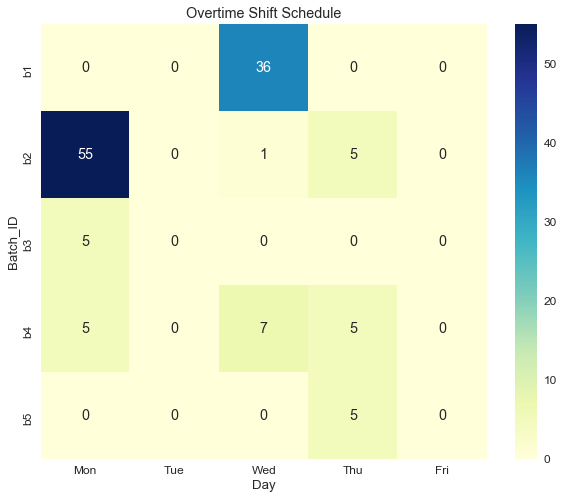

In [22]:
sns.set(font_scale = 1.2)
plt.figure(figsize= (10,8))
ax= sns.heatmap(p_ot, annot= True, cmap= 'YlGnBu').set_title('Overtime Shift Schedule')

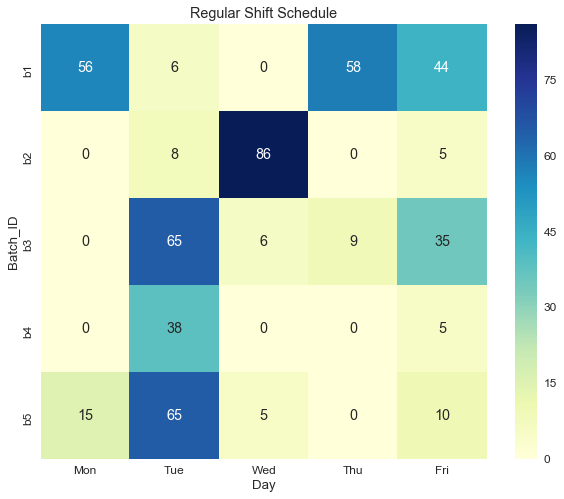

In [23]:
sns.set(font_scale = 1.2)
plt.figure(figsize= (10,8))
sns.heatmap(p_rt, annot= True, cmap= 'YlGnBu').set_title('Regular Shift Schedule')
plt.show()

<h3>Next Steps</h3>
Now that we've formulated and solved the linear program, let's talk about how we can make this more realistic. You could explore:

• <b>Adding changeover constraints-</b> everytime manufacturing switches from one batch to another, there is changeover time that needs to be accounted for. During this period there is no manufacturing happening, but that time still has cost associated with it.

• <b>Insufficient Capacity-</b> Right now, we are only considering 5 day's worth of available production capacity. How can we improve the model to handle jobs that are in excess of available production capacity? Maybe we need to have roll-over days?

• <b>Jobs that arrive mid-week-</b> In our model, we've assumed a 1-week lock. Which means that any jobs that we recieve throughout the week will only be scheduled for the following week starting Monday. Can we adjust the model such that it can schedule jobs that arrive mid-week in the same week?

<h2>References</h2>

• Optimization with PuLP: https://pythonhosted.org/PuLP/CaseStudies/index.html

• Caylie Cincera's Videos: https://youtu.be/5I0mhX0973o

• Ben Alex Keen's Blog: http://benalexkeen.com/linear-programming-with-python-and-pulp/
